# This is Bing's Version

# Imports and reading data

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [136]:
# Imports for Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import Adam

# Functions

In [137]:
def get_metrics(y_true, y_predict, print_scores = True):
    matrix_def = [['tn','fp'], ['fn','tp']]
    matrix = confusion_matrix(y_true, y_predict)
    tn, fp, fn, tp = matrix.ravel()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    misclass = 1-accuracy
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    if print_scores:
        print('Matrix Definition')
        print(np.array(matrix_def))
        print('')
        print('Confusion Matrix')
        print(matrix)
        print('')
        print('METRICS')
        print(f'accuracy: {accuracy}')
        print(f'misclass: {misclass}')
        print(f'sensitivity: {sensitivity}')
        print(f'specificity: {specificity}')
    else:
        return accuracy, misclass, sensitivity, specificity, precision

In [138]:
!ls west_nile/west_nile/input/weather.csv

west_nile/west_nile/input/weather.csv


In [200]:
df = pd.read_csv('west_nile/west_nile/input/train.csv')
df_test = pd.read_csv('west_nile/west_nile/input/test.csv')

In [140]:
spray_df = pd.read_csv('west_nile/west_nile/input/spray.csv')

In [141]:
weather_df = pd.read_csv('west_nile/west_nile/input/weather.csv')

# Train Cleaning: 

## Total mosquitos per trap:

In [142]:
cols = [col for col in df.columns if col not in ['NumMosquitos', 'WnvPresent']]
df = df.groupby(cols, as_index=False).sum()
df['WnvPresent'] = (df.WnvPresent>0).astype(int)

In [143]:
df[['Trap', 'Date', 'Species']].duplicated(keep=False).sum()

0

# Spray Cleaning:

##  Splitting Date into year/month/day:

In [144]:
spray_df['year'] = spray_df.Date.str[:4]
spray_df['month'] = spray_df.Date.str[5:7]
spray_df['day'] = spray_df.Date.str[-2:]

# EDA:

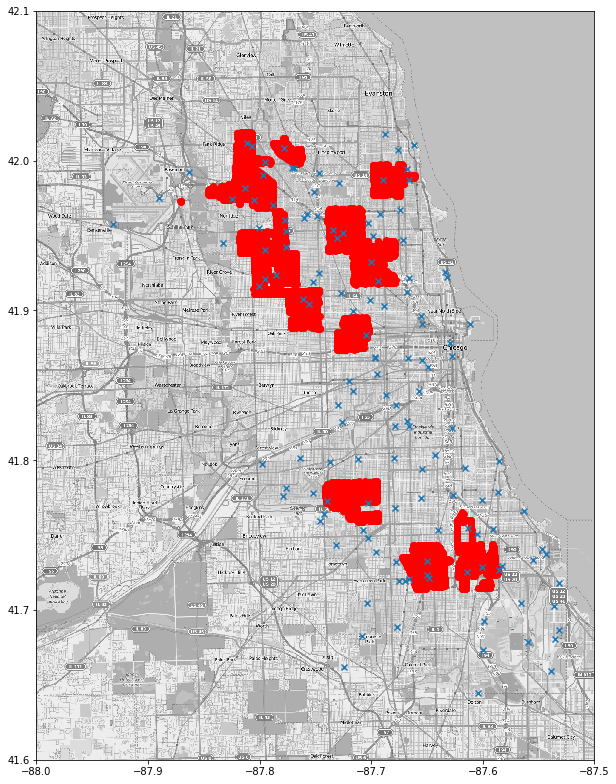

In [145]:

mapdata = np.loadtxt("west_nile/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
traps = df[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

spray_df = spray_df[spray_df['Longitude']>-88]
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
sprays = spray_df[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(sprays[:,0], sprays[:,1], c='r', alpha=1)
plt.scatter(locations[:,0], locations[:,1], marker='x')


In this plot, each x represents a trap location, and the red marks are areas sprayed.  
___

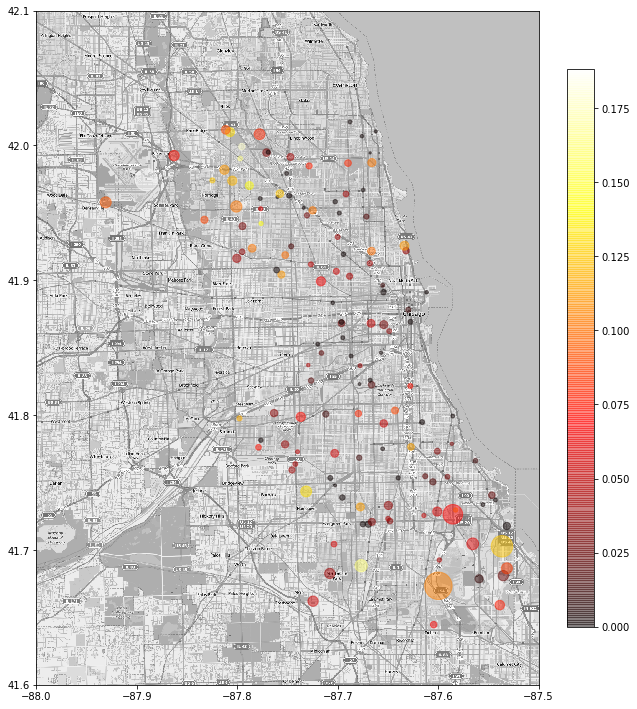

In [146]:
dfll = df.groupby(['Latitude', 'Longitude'],as_index=False).mean().copy()
traps = df[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
#plt.scatter(locations[:,0], locations[:,1], marker='x')
plt.scatter(dfll['Longitude'], dfll['Latitude'], c=dfll.WnvPresent, s=5*dfll.NumMosquitos, 
            marker='o',alpha=0.5, cmap='hot')
plt.colorbar(fraction=0.05)

#plt.scatter(df['Longitude'], df['Latitude'], c=df.WnvPresent, marker='x',)

In this plot, each bubble represents a mosquito trap.  The size represents the total number of mosquitos caught by the trap, and the color represents the percentage of the time the trap caught mosquitos with West Nile Virus
___

In [147]:
trap_df = df[df.Trap == 'T900']
wnvDates = trap_df[trap_df.WnvPresent ==1]['Date']

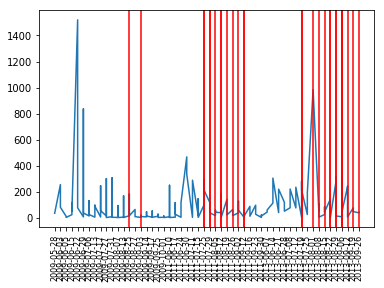

In [148]:
plt.plot(trap_df.Date, trap_df.NumMosquitos)
for d in wnvDates:
    plt.axvline(d, ymax=100, c='r')
plt.xticks(rotation='vertical', fontsize=8);

This is the total population of mosquitos at trap T900 in blue and instances where wnv was found to be present in red.

#### We need to split this by year
___


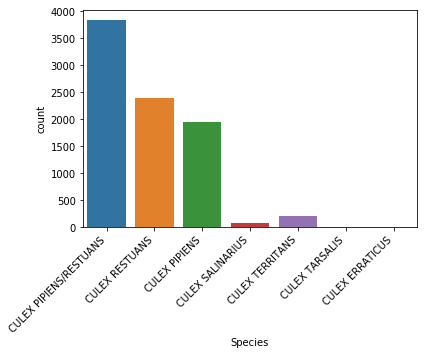

In [149]:
sns.countplot(x='Species', data=df)
plt.xticks(rotation=45, ha='right');

## Join the weather data to our Train DF

Tavg has 11 missing values.  Compute the average from the min and max

#### Impute Missing Values

In [150]:
missing_Tavg = weather_df[weather_df.Tavg == 'M'].index

weather_df.loc[missing_Tavg, 'Tavg'] = round((weather_df.loc[missing_Tavg, 'Tmax'] 
                                              + weather_df.loc[missing_Tavg, 'Tmin'])/2)

#### Convert dtype to integer

In [151]:
weather_df.Tavg = weather_df.Tavg.astype(int)

#### Join Average Temperature to DataFrame

In [152]:
AvgTemp = pd.DataFrame(weather_df.groupby('Date')['Tavg'].mean())
df = df.join(AvgTemp, on='Date')

In [153]:
AvgTemp

,Tavg
Date,
2007-05-01,67.5
2007-05-02,51.5
2007-05-03,57.0
2007-05-04,61.0
2007-05-05,60.0
2007-05-06,59.5
2007-05-07,66.0
2007-05-08,69.0
2007-05-09,69.5


In [154]:
df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Tavg
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,75.5
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,75.5
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,1,0,75.5
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0,75.5
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,1,0,75.5


#### Get trap_df again after adding average temperature

In [155]:
trap_df = df[df.Trap == 'T900']
wnvDates = trap_df[trap_df.WnvPresent ==1]['Date']

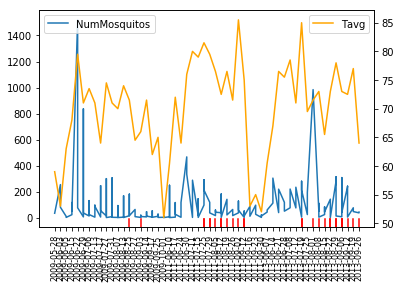

In [156]:
fig, ax1 = plt.subplots()
ax1.plot(trap_df.Date, trap_df.NumMosquitos)
plt.xticks(rotation='vertical', fontsize=8)
plt.legend(loc=2)
for d in wnvDates:
    plt.axvline(d, ymax=0.04, c='r')

ax2 = ax1.twinx()
ax2.plot(trap_df.Date, trap_df.Tavg, c='orange')
plt.legend()

In [157]:
df['LatAndLong'] = df.apply(lambda x: str(x.Latitude) +', ' + str(x.Longitude), axis=1)

### Working on function to check if a trap affected by spray

In [158]:
from geopy.distance import distance
from datetime import datetime as dt
from datetime import timedelta

def CheckSprayed( 
            trap_latitude, 
            trap_longitude, 
            spray_latitude,
            spray_longitude, 
            trap_date,
            spray_date,
            distance_limit, 
            days_limit, 
            gestation_days):

    dist_bool = False
    days_bool = False
        
    trap_l = (trap_latitude, trap_longitude)
    spray_l = (spray_latitude, spray_longitude)
    dist = distance(trap_l, spray_l).miles
    
    if dist < distance_limit:
        dist_bool = True
        
    trap_dt = dt.strptime(trap_date, "%Y-%m-%d")
    spray_dt = dt.strptime(spray_date, "%Y-%m-%d")
    if spray_dt + timedelta(days=gestation_days) < trap_dt < spray_dt + timedelta(days=gestation_days) + timedelta(days=days_limit):
        days_bool = True
    
    isSprayed = dist_bool & days_bool
    return isSprayed
    #print(isSprayed)

In [159]:
# testing of function
trap_longitude = df.Longitude.iloc[0]
trap_latitude = df.Latitude.iloc[0]
spray_longitude = spray_df.Longitude.iloc[0]
spray_latitude = spray_df.Latitude.iloc[0]
trap_date = df.Date.iloc[0]
spray_date =  spray_df.Date.iloc[0]
distance_limit = 50
days_limit = 7
gestation_days = 14
CheckSprayed(trap_latitude, trap_longitude, spray_latitude, spray_longitude, 
        trap_date, spray_date, distance_limit, days_limit, gestation_days)

False

In [160]:
# for index, row in df.iterrows():
#     if row > mean:
#         print (index)

In [161]:
# Trying out date time functionality
trap_dt = dt.strptime(trap_date, "%Y-%m-%d")
spray_dt = dt.strptime(spray_date, "%Y-%m-%d")

trap_dt < spray_dt

a = spray_dt 
c = spray_dt + timedelta(days = 700) 
b = trap_dt+ timedelta(days = 2700)

a < c < b

True

## Work on creating apply to calculate "IsSprayed" column

In [162]:
df['IsSprayed'] = 1

#### Something isn't working right with my function...

In [163]:
trap = df.iloc[5000, :]
dist_lim = 2000
day_lim = 2000
gest_days = 1

chkspraylist = []

for sp_index, spray in spray_df.iterrows():
    chkspray = CheckSprayed(trap.Latitude,
                 trap.Longitude, 
                 spray.Latitude,
                 spray.Longitude,
                 trap.Date,
                 spray.Date,
                 dist_lim,
                 day_lim,
                 gest_days
                )
    chkspraylist.append(chkspray)

print(sum(chkspraylist))
    

0


#### Turns out there is only 10 days of spray data...  Let's find out which days

In [164]:
spray_df.Date.value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
Name: Date, dtype: int64

In [165]:
min(spray_df[spray_df.Date == '2013-08-15'].Latitude), max(spray_df[spray_df.Date == '2013-08-15'].Latitude)

(41.887825, 41.966531666666704)

In [166]:
min(spray_df[spray_df.Date == '2013-08-15'].Longitude), max(spray_df[spray_df.Date == '2013-08-15'].Longitude)

(-87.8184083333333, -87.745625)

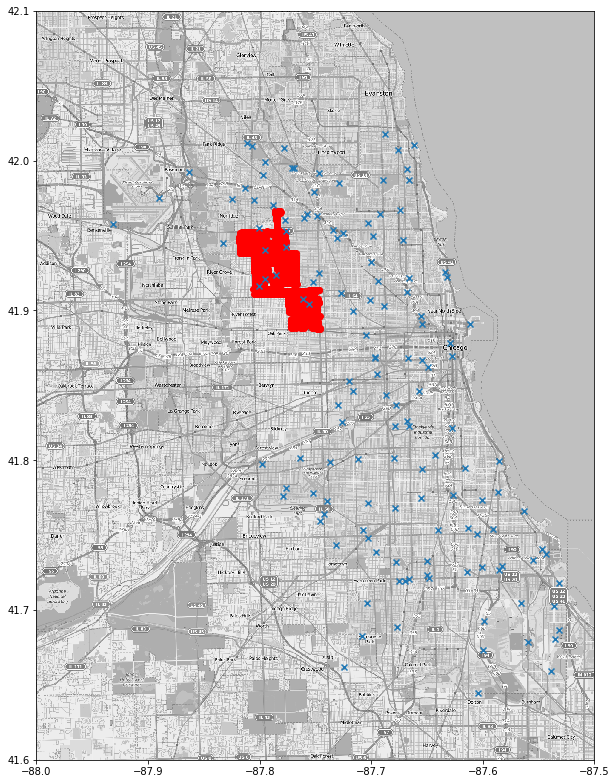

In [167]:

mapdata = np.loadtxt("west_nile/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
traps = df[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

spray_df = spray_df[spray_df['Longitude']>-88]
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
sprays = spray_df[['Longitude', 'Latitude']].drop_duplicates().values

sprays = spray_df[spray_df.Date == '2013-08-15'][['Longitude', 'Latitude']].values

plt.scatter(sprays[:,0], sprays[:,1], c='r', alpha=1)
plt.scatter(locations[:,0], locations[:,1], marker='x')


# Setting up a quick workflow

## Keep only relevant columns

In [168]:
cols_keep = ['Date','Species','Latitude','Longitude','NumMosquitos','Tavg', 'WnvPresent']

df = df[cols_keep]

In [169]:
df.head(1)

,Date,Species,Latitude,Longitude,NumMosquitos,Tavg,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.867108,-87.654224,1,75.5,0


## Feature Engineering

#### Create boolean - WnvSpecies
- Discussion - Should we make it like this, or split out by species?
- I think we should set up the data for neural net?

In [170]:
wnvspeciesmap = {
    'CULEX PIPIENS/RESTUANS': 1,
    'CULEX RESTUANS': 1,
    'CULEX PIPIENS': 1,
    'CULEX TERRITANS': 0,
    'CULEX SALINARIUS': 0,
    'CULEX TARSALIS': 0,
    'CULEX ERRATICUS': 0,
    'UNSPECIFIED CULEX':1
}

df['WnvSpecies'] = df.Species.map(wnvspeciesmap)

#### Extract Month from Date

In [171]:
df['Month'] = df.Date.str[5:7]

#### Set up process for one-hot encoding

In [172]:
df = pd.get_dummies(df, columns=['Month', 'Species'])

#### Drop Date Column

In [173]:
cols_to_drop = ['Date']

df = df[[col for col in df.columns if col not in cols_to_drop]]


In [174]:
df.head()

,Latitude,Longitude,NumMosquitos,Tavg,WnvPresent,WnvSpecies,Month_05,Month_06,Month_07,Month_08,Month_09,Month_10,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,41.867108,-87.654224,1,75.5,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0
1,41.867108,-87.654224,2,75.5,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
2,41.862292,-87.648860,1,75.5,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
3,41.896282,-87.655232,1,75.5,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
4,41.907645,-87.760886,1,75.5,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0


### Split up Features and Target Variables

In [175]:
target = 'WnvPresent'
features = [col for col in df.columns if col != target]
y = df[target]
X = df[features]

### Train Test Split

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

### Use Standard Scalar

In [177]:
ss = StandardScaler()
X_train_ss = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_ss = ss.transform(X_test)

### Over-sample the minority class?

In [178]:
y_train.value_counts()

0    6013
1     343
Name: WnvPresent, dtype: int64

In [179]:
num_oversample = y_train.value_counts()[0]-y_train.value_counts()[1]
num_oversample

5670

In [180]:
num_oversample = int(num_oversample/5)
num_oversample

1134

In [181]:
df2 = X_train_ss.copy()
df2['target'] = y_train

In [182]:
df2.shape

(6356, 19)

In [183]:
index_to_add = np.random.choice(df2[df2.target==1].index,size=num_oversample)

oversampling = df2.loc[index_to_add,:]
df_os = pd.concat([df2, oversampling])

In [184]:
df_os.target.value_counts()

0    6013
1    1477
Name: target, dtype: int64

## Split X and y again

In [185]:
X_train_os = df_os.drop('target',axis=1)
y_train_os = df_os['target']

-----------------------

### Create simple model

In [186]:
lr = LogisticRegression()
lr.fit(X_train_ss, y_train)
lr.score(X_train_ss, y_train), lr.score(X_test_ss, y_test)

(0.9485525487728131, 0.9485606418121756)

In [187]:
get_metrics(lr.predict(X_test_ss), y_test)

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[2000  104]
 [   5   10]]

METRICS
accuracy: 0.9485606418121756
misclass: 0.05143935818782441
sensitivity: 0.6666666666666666
specificity: 0.9505703422053232


## Try modeling using oversampled data

In [188]:
lr = LogisticRegression()
lr.fit(X_train_os, y_train_os)
lr.score(X_train_os, y_train_os), lr.score(X_test_ss, y_test)

(0.8324432576769025, 0.9433695139216611)

In [189]:
get_metrics(lr.predict(X_test_ss), y_test)

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[1968   83]
 [  37   31]]

METRICS
accuracy: 0.9433695139216611
misclass: 0.05663048607833887
sensitivity: 0.45588235294117646
specificity: 0.9595319356411507


## Try Neural Network??

In [190]:
X_train.shape

(6356, 18)

In [191]:
model = Sequential()
model.add(Dense(18, activation='relu', input_dim=X_train.shape[1])) #Makes this dynamic
model.add(Dense(20, activation='relu')) #Makes this dynamic
model.add(Dense(1, activation=None))

In [192]:
adam = Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

In [193]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

Train on 6356 samples, validate on 2119 samples
Epoch 1/30
6356/6356 [==============================] - 1s 94us/step - loss: 9.1327 - acc: 0.4511 - val_loss: 1.0399 - val_acc: 0.2808
Epoch 2/30
6356/6356 [==============================] - 0s 48us/step - loss: 2.1593 - acc: 0.4561 - val_loss: 0.1141 - val_acc: 0.9401
Epoch 3/30
6356/6356 [==============================] - 0s 48us/step - loss: 0.2005 - acc: 0.8848 - val_loss: 0.0679 - val_acc: 0.9476
Epoch 4/30
6356/6356 [==============================] - 0s 48us/step - loss: 0.0617 - acc: 0.9454 - val_loss: 0.0560 - val_acc: 0.9471
Epoch 5/30
6356/6356 [==============================] - 0s 48us/step - loss: 0.0546 - acc: 0.9467 - val_loss: 0.0644 - val_acc: 0.9471
Epoch 6/30
6356/6356 [==============================] - 0s 49us/step - loss: 0.0514 - acc: 0.9465 - val_loss: 0.0503 - val_acc: 0.9471
Epoch 7/30
6356/6356 [==============================] - 0s 47us/step - loss: 0.0500 - acc: 0.9463 - val_loss: 0.0472 - val_acc: 0.9481
Epoch 8

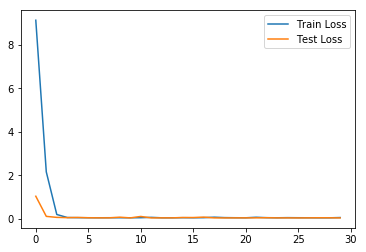

In [194]:
plt.plot(history.history['loss'], label= 'Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')

plt.legend()

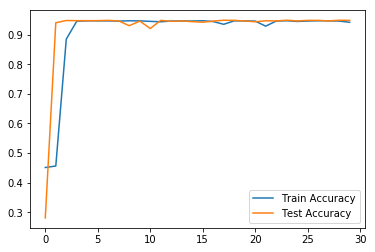

In [195]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.legend()

## Check out Max's work

In [196]:
codes = {code: [0]*weather_df.shape[0] for codes in weather_df.CodeSum.unique() for code in codes.split()}


weather_df = weather_df.join(pd.DataFrame(codes))
for i, codesum in enumerate(weather_df.CodeSum):
    for code in codesum.split():
        weather_df.at[i, code] = 1
        

codes_df = weather_df.groupby('Date', as_index=True)[list(codes.keys())].max()
# df = df.join(codes_df, on='Date', rsuffix="_code_")

In [211]:
codes_df = weather_df.groupby('Date', as_index=True)[list(codes.keys())].max()

In [198]:
codes_df.head()

,Date,BR,HZ,RA,TSRA,VCTS,FU,TS,DZ,BCFG,FG+,MIFG,FG,SQ,SN,VCFG,GR
0,2007-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-02,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007-05-03,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2007-05-04,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2007-05-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [216]:
df.join(codes_df, on='Date', rsuffix="_code_")

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,TS,DZ,BCFG,FG+,MIFG,FG,SQ,SN,VCFG,GR
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,0,0,0,0,0,0,0,0,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,0,0,0,0,0,0,0,0,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,0,0,0,0,0,0,0,0,0,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,0,0,0,0,0,0,0,0,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,0,0,0,0,0,0,0,0,0
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,...,0,0,0,0,0,0,0,0,0,0
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,...,0,0,0,0,0,0,0,0,0,0
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,0,0,0,0,0,0,0,0,0,0
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,0,0,0,0,0,0,0,0,0,0
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,...,0,0,0,0,0,0,0,0,0,0


In [206]:
df.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

In [209]:
codes_df.index = codes_df.Date

In [210]:
codes_df.head()

,Date,BR,HZ,RA,TSRA,VCTS,FU,TS,DZ,BCFG,FG+,MIFG,FG,SQ,SN,VCFG,GR
Date,,,,,,,,,,,,,,,,,
2007-05-01,2007-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-05-02,2007-05-02,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-05-03,2007-05-03,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-05-04,2007-05-04,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-05-05,2007-05-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
